In [2]:
import os
import keras
import tensorflow as tf

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Configuration

In [3]:
class CFG:
    # General settings
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b0_imagenet"  # Name of pretrained classifier
    image_size = (224, 224)  # Input image size

    # Training settings
    batch_size = 96  # Batch size
    lr_mode = "cos"  # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches

    # Dataset settings
    num_folds = 5  # Number of folds to split the dataset
    fold = 0  # Which fold to set as validation data
    class_names = ['Malignant' , 'Benign',]
    num_classes = 1
    epochs = 50

In [4]:
tf.random.set_seed(CFG.seed)

# Load Dataset

In [5]:
BASE_PATH = "./kaggle"

In [6]:
metadata = pd.read_csv(f'{BASE_PATH}/ISIC_2019_Training_Metadata.csv')
ground_truth = pd.read_csv(f'{BASE_PATH}/ISIC_2019_Training_GroundTruth.csv')
# Concatenate the two DataFrames based on the 'image' column
merge_df = pd.merge(ground_truth, metadata, on='image').drop('lesion_id', axis=1)
merge_df['target'] = merge_df[['MEL', 'BCC', 'AK', 'SCC']].sum(axis=1) # 1 for Malignant
diagnosis_map = {0: 'benign', 1: 'malignant'}
merge_df['diagnosis'] = merge_df['target'].map(diagnosis_map)
df = merge_df.loc[:, ['image', 'target', 'diagnosis']]
df['images'] = f'{BASE_PATH}/input/ISIC-2019/' + df['image'] + '.jpg'
# data['anatom_site_general'] = data['anatom_site_general'].replace(['lateral torso', 'anterior torso', 'posterior torso'], 'torso')
df.head()

,image,target,diagnosis,images
0,ISIC_0000000,0.0,benign,./kaggle/input/ISIC-2019/ISIC_0000000.jpg
1,ISIC_0000001,0.0,benign,./kaggle/input/ISIC-2019/ISIC_0000001.jpg
2,ISIC_0000002,1.0,malignant,./kaggle/input/ISIC-2019/ISIC_0000002.jpg
3,ISIC_0000003,0.0,benign,./kaggle/input/ISIC-2019/ISIC_0000003.jpg
4,ISIC_0000004,1.0,malignant,./kaggle/input/ISIC-2019/ISIC_0000004.jpg


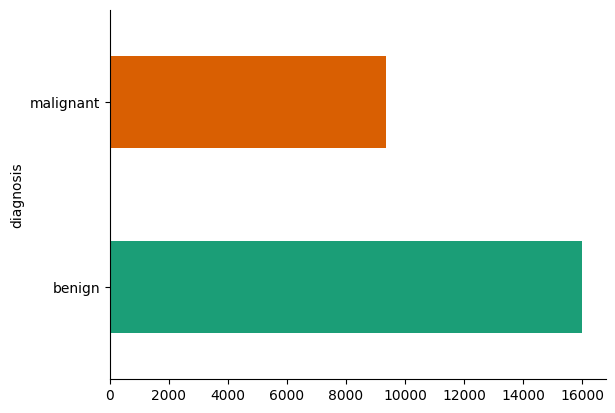

In [7]:
# @title diagnosis

import seaborn as sns
df.groupby('diagnosis').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [8]:
# Split the dataset into features and target
X = df[["images"]]
y = df["target"]

# Convert target values to float32
y = y.astype('float32')

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X, y = X_test, y_test
X_validation, X_test, y_validation, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

# Create a TensorFlow dataset from the preprocessed data
def load_and_preprocess_image(image_path):
    # Read and preprocess image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, CFG.image_size)  # adjust size as needed
    return image

def create_tf_dataset(X, y, batch_size=32, shuffle=True,repeat =True):
    image_paths = X['images'].tolist()
    X.drop('images',axis=1,inplace=True)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, y))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))

    # Read and preprocess images, include them in the batch
    def load_image(image_path, label):
        image = load_and_preprocess_image(image_path)
        return image, label

    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

batch_size = CFG.batch_size
train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
validation_dataset = create_tf_dataset(X_validation, y_validation, batch_size=batch_size, shuffle=False)
test_dataset = create_tf_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Setup base model (EfficientNet)

In [9]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [10]:
# Create the base model from the pre-trained model EfficientNet V2
input_shape = CFG.image_size + (3,)
base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                    include_top=False,
                                                    pooling="avg",
                                                    weights='imagenet')
base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()



Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalizat

In [11]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Create Model

In [12]:
# Create the model
inputs = tf.keras.Input(shape=input_shape)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(2048, activation="selu")(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(1024, activation="selu")(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile model

In [13]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              2623488   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
 dense (Dense)               (None, 1)                 1025      
          

# Train model

In [14]:
initial_epochs = CFG.epochs

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50

159/159 [==============================] - 234s 1s/step - loss: 0.6839 - accuracy: 0.7311 - val_loss: 0.4706 - val_accuracy: 0.7633
Epoch 2/50
159/159 [==============================] - 219s 1s/step - loss: 0.4661 - accuracy: 0.7733 - val_loss: 0.4406 - val_accuracy: 0.7870
Epoch 3/50
159/159 [==============================] - 219s 1s/step - loss: 0.4560 - accuracy: 0.7763 - val_loss: 0.4321 - val_accuracy: 0.7862
Epoch 4/50
159/159 [==============================] - 219s 1s/step - loss: 0.4410 - accuracy: 0.7853 - val_loss: 0.4649 - val_accuracy: 0.7728
Epoch 5/50
159/159 [==============================] - 218s 1s/step - loss: 0.4353 - accuracy: 0.7883 - val_loss: 0.4699 - val_accuracy: 0.7631
Epoch 6/50
159/159 [==============================] - 218s 1s/step - loss: 0.4342 - accuracy: 0.7890 - val_loss: 0.4172 - val_accuracy: 0.8066
Epoch 7/50
159/159 [==============================] - 212s 1s/step - loss: 0.4208 - accuracy: 0.7950 - val_loss: 0.4324 - val_accuracy: 0.794

# Plot Training

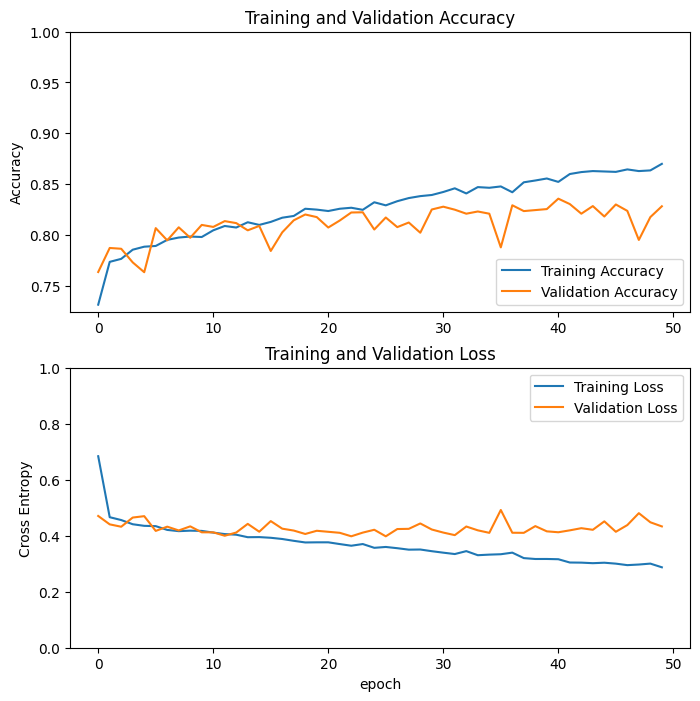

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
from sklearn.metrics import roc_curve
y_pred = model.predict(test_dataset).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

53/53 [==============================] - 50s 919ms/step


In [17]:
from sklearn.metrics import auc
auc_score = auc(fpr, tpr)

In [18]:
y_pred = tf.where(y_pred < 0.5, 0, 1)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      3199
         1.0       0.78      0.72      0.75      1868

    accuracy                           0.82      5067
   macro avg       0.81      0.80      0.81      5067
weighted avg       0.82      0.82      0.82      5067



In [20]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[2815  384]
 [ 518 1350]]


# Fine tune base model

In [21]:
base_model.trainable = True

In [22]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  271


In [23]:
# Fine-tune from this layer onwards
start_fine_tune_at = 261

# Freeze all the layers before the `start_fine_tune_at` layer
for layer in base_model.layers[:start_fine_tune_at]:
  layer.trainable = False

# Recompile model

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              2623488   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              2098176   
                                                             

# Retrain model

In [25]:
fine_tune_epochs = CFG.epochs
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)


Epoch 51/100
159/159 [==============================] - 218s 1s/step - loss: 0.2551 - accuracy: 0.8867 - val_loss: 0.4248 - val_accuracy: 0.8358
Epoch 52/100
159/159 [==============================] - 210s 1s/step - loss: 0.2450 - accuracy: 0.8912 - val_loss: 0.4244 - val_accuracy: 0.8334
Epoch 53/100
159/159 [==============================] - 210s 1s/step - loss: 0.2357 - accuracy: 0.8930 - val_loss: 0.4594 - val_accuracy: 0.8326
Epoch 54/100
159/159 [==============================] - 211s 1s/step - loss: 0.2321 - accuracy: 0.8966 - val_loss: 0.4373 - val_accuracy: 0.8411
Epoch 55/100
159/159 [==============================] - 211s 1s/step - loss: 0.2253 - accuracy: 0.8976 - val_loss: 0.4417 - val_accuracy: 0.8348
Epoch 56/100
159/159 [==============================] - 211s 1s/step - loss: 0.2213 - accuracy: 0.8998 - val_loss: 0.4524 - val_accuracy: 0.8346
Epoch 57/100
159/159 [==============================] - 211s 1s/step - loss: 0.2189 - accuracy: 0.9012 - val_loss: 0.4461 - val_ac

# Plot retraining

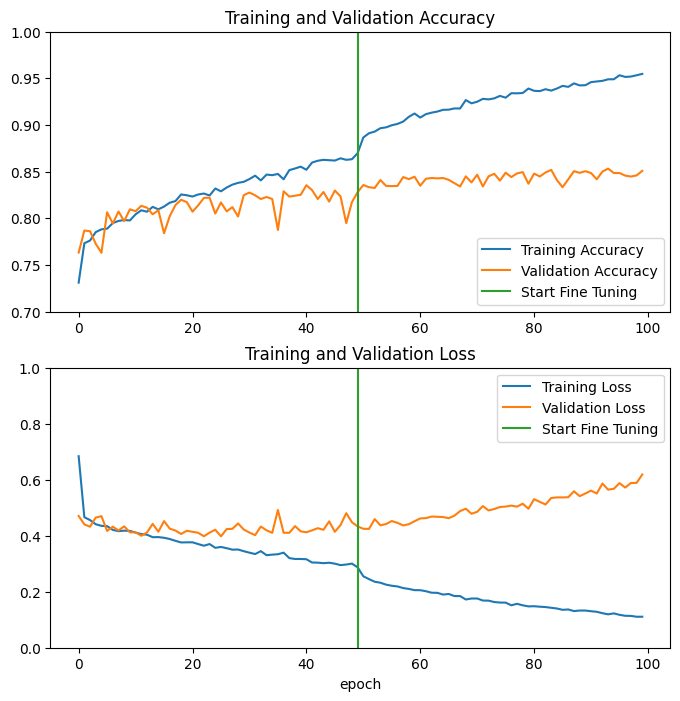

In [26]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.7, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluate training

In [27]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

53/53 [==============================] - 49s 915ms/step - loss: 0.6584 - accuracy: 0.8413
Test accuracy : 0.8413262367248535


In [28]:
from sklearn.metrics import roc_curve
fine_y_pred = model.predict(test_dataset).ravel()
fine_fpr, fine_tpr, fine_thresholds = roc_curve(y_test, fine_y_pred)

53/53 [==============================] - 50s 918ms/step


In [29]:
from sklearn.metrics import auc
fine_auc_score = auc(fine_fpr, fine_tpr)

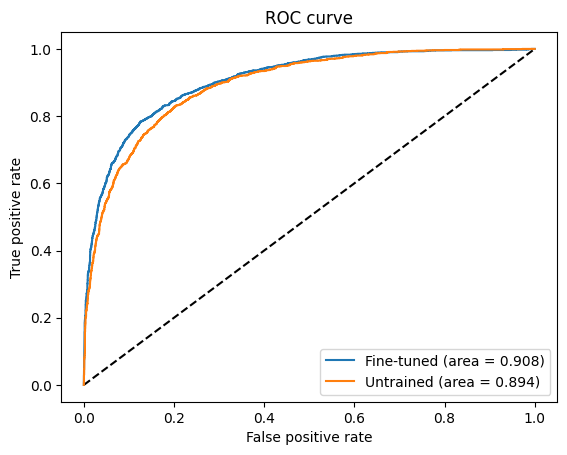

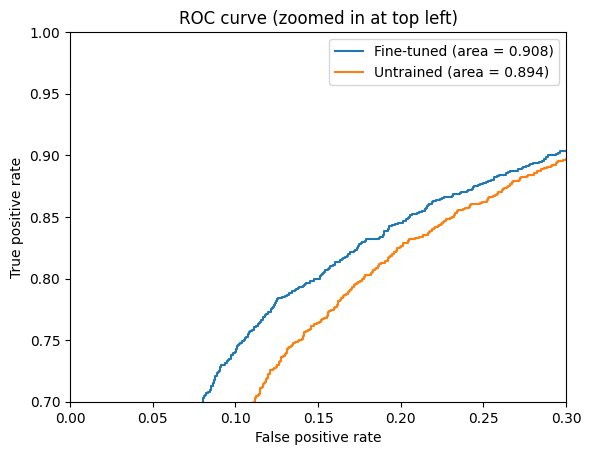

In [30]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fine_fpr, fine_tpr, label='Fine-tuned (area = {:.3f})'.format(fine_auc_score))
plt.plot(fpr, tpr, label='Untrained (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.3)
plt.ylim(0.7, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fine_fpr, fine_tpr, label='Fine-tuned (area = {:.3f})'.format(fine_auc_score))
plt.plot(fpr, tpr, label='Untrained (area = {:.3f})'.format(auc_score))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [31]:
fine_y_pred = tf.where(fine_y_pred < 0.5, 0, 1)

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, fine_y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88      3199
         1.0       0.80      0.75      0.78      1868

    accuracy                           0.84      5067
   macro avg       0.83      0.82      0.83      5067
weighted avg       0.84      0.84      0.84      5067



In [33]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, fine_y_pred))

[[2857  342]
 [ 462 1406]]


In [34]:
keras.utils.plot_model(model, show_shapes=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [35]:
model.save('my_model.keras')